In [1]:
import sklearn
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import random
import statistics
import matplotlib.pyplot as plt


import pandas as pd
import io
import requests
import warnings
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten

warnings.filterwarnings("ignore")    

def shuffle(df, n=1, axis=0):     
  df = df.copy()
  for _ in range(n):
    df.apply(np.random.shuffle, axis=axis)
  return df

Using TensorFlow backend.


## Shuffle Training X values

In [0]:
url = "https://raw.githubusercontent.com/atfrank/CS-Annotate/Kexin/data/train_features_3.csv"
s=requests.get(url).content
training_X = pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ' ')
training_X = shuffle(training_X)
trainX = training_X.values

url = "https://raw.githubusercontent.com/atfrank/CS-Annotate/Kexin/data/train_target_3.csv"
s=requests.get(url).content
training_y = pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ' ')

url = "https://raw.githubusercontent.com/atfrank/CS-Annotate/Kexin/data/test_features_3.csv"
s=requests.get(url).content
testing_X = pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ' ')
testX = testing_X.values

url = "https://raw.githubusercontent.com/atfrank/CS-Annotate/Kexin/data/test_target_3.csv"
s=requests.get(url).content
testing_y = pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ' ')

Structural Feature - f1 score
astack - 0.738371964328015
nastack - 0.7359432183653101
pair - 0.6597303377899426
pucker_C1p_exo - 0.9660239920535874
pucker_C2p_endo - 0.9351934391157068
pucker_C2p_exo - 0.8554778966194831
pucker_C3p_endo - 0.7397860382792931
pucker_C3p_exo - 0.9753897047767031
pucker_C4p_exo - 0.9074634785153741
sasa - 0.8094260587289378
syn_anti - 0.9404077896984796


<Figure size 432x288 with 0 Axes>

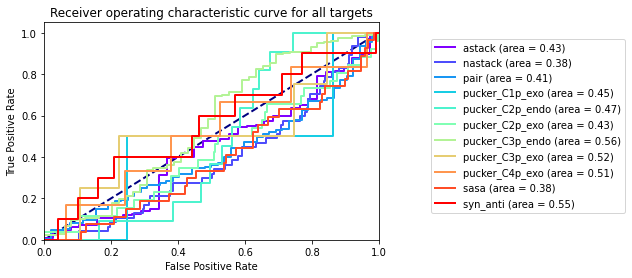

In [3]:
feature_list = ['astack','nastack','pair','pucker_C1p_exo','pucker_C2p_endo','pucker_C2p_exo','pucker_C3p_endo','pucker_C3p_exo','pucker_C4p_exo','sasa','syn_anti']

import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, len(feature_list)))

i=0
plt.figure()
lw = 2
__, ax = plt.subplots()
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

print("Structural Feature - f1 score")
for structural_feature in feature_list:
  training_y_struct = training_y[[structural_feature]]
  trainy = training_y_struct.values

  testing_y_struct = testing_y[[structural_feature]]
  testy = testing_y_struct.values
  # setup scaler
  temp = list()
  scaler = StandardScaler()
  scaler.fit(trainX)

  # transform input
  trainX_scaled = scaler.transform(trainX)
  testX_scaled = scaler.transform(testX)

  clf = MLPClassifier(hidden_layer_sizes=(50,100,50), max_iter=100, activation = 'logistic', learning_rate = 'invscaling', validation_fraction = 0.2)

  clf.fit(trainX_scaled, np.int_(trainy))
  y_true, y_pred, y_pred_2 = np.int_(testy) , clf.predict(testX_scaled), clf.predict_proba(testX_scaled)
  y_pred_2 = np.array([(y_pred_2[i][0]*0+y_pred_2[i][1]*1) for i in range(len(y_pred_2))])
  y_true = np.array([y_true[i][0] for i in range(len(y_true))])
  report = classification_report(y_true, y_pred, output_dict=True)
  temp.append(report['weighted avg']['f1-score'])

  AUC = sklearn.metrics.roc_auc_score(y_true, y_pred_2, average = 'weighted')
  fpr,tpr,thresholds = sklearn.metrics.roc_curve(y_true, y_pred_2, pos_label = 1)
  
  ax.plot(fpr, tpr, color=colors[i],
          lw=lw, label=f'{structural_feature} (area = %0.2f)' % AUC)
  
  print(structural_feature,'-' ,report['weighted avg']['f1-score'])
  i+=1

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve for all targets')
plt.legend(loc="lower right", bbox_to_anchor=(1.75, 0.1))
plt.show()